# MOUNTING DRIVE

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#@title Set up Directory

# project directory
%cd '/content/drive/MyDrive/Soft-computing-eXtended'

/content/drive/MyDrive/Soft-computing-eXtended


In [ ]:
import pandas as pd
covid_tweet_dataset = "tweetid_sentiments_emotions.csv"
api_keys = "config.json" #@param {type: "string"}

# DATASET SAMPLING

In [ ]:
#@title Covid-19 subset preview
covid_subset = pd.read_csv(covid_tweet_dataset, 
                           #skiprows=range(1,5932184), 
                           #nrows=6158058-5932184, 
                           usecols=[0,17,19,21])


In [ ]:
covid_subset.sample(10)

In [ ]:
print("Columns:", covid_subset.columns)
print("Length:", len(covid_subset))
print("Null entries:\n", covid_subset.isnull().sum().sum())

Columns: Index(['tweet_ID', 'sentiment_category', 'keyword_used', 'date_stamp'], dtype='object')
Length: 6166151
Null entries:
 0


# Check tweet_IDs by dates and months

In [ ]:
import pandas as pd 
#@title Grouping by dates
covid_tweet_dataset = "tweetid_sentiments_emotions.csv"
date_groups = pd.read_csv(covid_tweet_dataset, usecols=[0,21]).groupby('date_stamp')
first = date_groups.get_group(list(date_groups.groups.keys())[0]).iloc[0,1][:-9]
last = date_groups.get_group(list(date_groups.groups.keys())[len(date_groups)-1]).iloc[-1,1][:-9]
count=0
print(first, "and", last)
print('number of days:', len(date_groups))
print('tweets\t date\t\tcumulative count')
for each in list(date_groups.groups.keys()):
  count+=len(date_groups.get_group(each))
  print(len(date_groups.get_group(each)),'\t',date_groups.get_group(each).iloc[0,1][:-9],'\t',count)

ParserError: ignored

In [ ]:
#@title Get index range by month { run: "auto", vertical-output: true, display-mode: "both" }
#@markdown between 2020-01-28 and 2021-01-01
month = 7 #@param {type:"slider", min:1, max:13, step:1}
skip_days = sum([4,29,31,30,31,30,31,31,30,31,30,31,1][:month-1])
days = [4,29,31,30,31,30,31,31,30,31,30,31,1][month-1] + skip_days
skiprows = date_groups.get_group(list(date_groups.groups.keys())[skip_days]).iloc[0].name
nrows = date_groups.get_group(list(date_groups.groups.keys())[days-1]).iloc[-1].name-skiprows
skiprows,nrows

(3900117, 626889)

# Twitter API V2 Calls to Fetch Bulk Tweets

In [ ]:
!pip install tweepy==4.0.0

     |████████████████████████████████| 60 kB 3.2 MB/s 
  Attempting uninstall: tweepy
    Found existing installation: tweepy 3.10.0
    Uninstalling tweepy-3.10.0:
      Successfully uninstalled tweepy-3.10.0


In [ ]:
!pip install tweepy --upgrade

     |████████████████████████████████| 76 kB 2.7 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: tweepy
    Found existing installation: tweepy 4.0.0
    Uninstalling tweepy-4.0.0:
      Successfully uninstalled tweepy-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
#@title Run this cell to load your api keys
import json
with open(api_keys, 'r') as infile:
  keys = json.load(infile)

In [ ]:
#@title Connecting to twitter using multiple accounts
from __future__ import print_function
import getopt
import logging
import os
import sys
from time import sleep
import tweepy

api = []
for each in keys:
  auth = tweepy.OAuthHandler(each['CONSUMER_KEY'], each['CONSUMER_SECRET'])
  auth.set_access_token(each['OAUTH_TOKEN'], each['OAUTH_TOKEN_SECRET'])
  api.append(tweepy.API(auth,wait_on_rate_limit=True))#, wait_on_rate_limit_notify=True))

In [ ]:
#@title Function *status_full_text(Status)* to get specific columns from Status object
def status_full_text(status):
  if hasattr(status, "retweeted_status"):  # Check if Retweet
    try:
      print(status.retweeted_status.extended_tweet["full_text"])
    except AttributeError:
      try:
        return status.retweeted_status.full_text
      except:
        return None
  else:
    try:
      return status.extended_tweet["full_text"]
    except AttributeError:
      try:
        return status.full_text
      except:
        return None

In [ ]:
#@title Function to get tweets and store in csv file: get_tweets(tweet_dataframe,output_csv_file)
#@markdown required: tweepy v4.7*
def get_tweets(tweet_list,output_csv):
  backoff_counter = 1
  count = 0
  HTTP_retry = 0
  _api = api[0]

  batch_size = 50

  # getting full text from tweet ids
  for i in range(0,len(tweet_list),batch_size):
    count=i
    try:
      batch = list(tweet_list.tweet_ID[i:i+batch_size])
      #statuses = _api.statuses_lookup(batch, include_entities=False, trim_user=True, tweet_mode='extended')
      statuses = _api.lookup_statuses(batch, include_entities=False, trim_user=True, tweet_mode='extended', map=True, include_ext_alt_text=False, include_card_uri=False) #tweepy v4.7.*

      #status = _api.get_status(id=batch, include_entities=False, trim_user=True, tweet_mode='extended')
      full_texts = [status_full_text(status) for status in statuses]
      #print(len(tweet_list[i:i+batch_size]))
      #print(len(tweet_list[i:i+batch_size]['full_text']))
      #print(len(tweet_list['full_text'][i:i+batch_size]))
      #j = int(input())
      tweet_list['full_text'][i:i+batch_size] = full_texts
      
      tweet_list.iloc[i:i+batch_size].to_csv(output_csv,mode='a',header=False)
      i += batch_size
      
      #error handle resets
      HTTP_retry = 0
      if (i+1)%1000 == 0:
        _api = api[0]
        print("Changed api. Done", 100*i/len(tweet_list),"%.")
      elif (i+1)%500 == 0:
        _api = api[1]
        print("Changed api. Done", 100*i/len(tweet_list),"%.")
    except KeyboardInterrupt:
      print("Keyboard Interrupt. Done", 100*i/len(tweet_list),"%.")
      count=i
      break
    except tweepy.errors.TweepyException as e:
      #print("Done", 100*count/len(tweet_list),"%. Error", e.api_code, "-", e.args[0][0]['message'], end=" ")
      if e.api_code in [34,63,144,179,401,403,404]:
        # skipping tweet
        i += batch_size
        continue
      elif e.api_code == 429:
        print("Done", 100*i/len(tweet_list),"%. Error", e.api_code, "-", e.args[0][0]['message'], end=" ")
        print("Waiting for", 60*backoff_counter, "seconds.")
        sleep(60*backoff_counter)
        backoff_counter += 1
      elif e.api_code == 4104:
        if(HTTP_retry < 2):
          print("Connection reset by peer. Retrying ", HTTP_retry, "time.")
          HTTP_retry += 1
        else:
          print("Aborting due to connection error.")
          count=i
          break
      else:
        # logging unknown error
        print("Done", 100*i/len(tweet_list),"%.", end = " ")
        try:
          print("Error", e.api_code, "-", e.args[0][0]['message'], "Skipping.")
        except:
          # skipping unknown next level error
          continue
        i += batch_size
      continue
  
  print("Done", 100*count/len(tweet_list),"%.")
  
  print("Processed tweet ids:", count, " Remaining tweets:", len(tweet_list)-len(output_csv))
  return i

In [ ]:
#@title Function to get tweets and store in csv file: get_tweets(tweet_dataframe,output_csv_file)
#@markdown required: tweepy v3.*
def get_tweets(tweet_list,output_csv):
  backoff_counter = 1
  count = 0
  HTTP_retry = 0
  _api = api[0]

  # getting full text from tweet ids
  for each in tweet_list.tweet_ID[:]:
    try:
      status = _api.get_status(id=each, include_entities=False, trim_user=True, tweet_mode='extended')
      tweet_list.at[count,'full_text'] = status.full_text
      tweet_list.iloc[[count]].to_csv(output_csv,mode='a',header=False)
      count+=1
      
      #error handle resets
      HTTP_retry=0
      if (count+1)%500 == 0:
        _api = api[0]
        print("Changed api. Done", 100*count/len(tweet_list),"%.")
      elif (count+1)%250 == 0:
        _api = api[1]
        print("Changed api. Done", 100*count/len(tweet_list),"%.")
        """
        e = tweepy.error.TweepError(api_code=429,reason="{'code':429,'message':'Manual rate limit reached.'}")
        e.args = [[{'code':429,'message':'Manual rate limit reached.'}]]
        backoff_counter = 1;
        raise(e)
        """
    except KeyboardInterrupt:
      print("Keyboard Interrupt. Done", 100*count/len(tweet_list),"%.")
      return count
    #except tweepy.error.RateLimitError:
      #if (count+1)%500 == 0:
        #_api = api[0]
        #print("Changed api")
      #elif (count+1)%250 == 0:
        #_api = api[1]
        #print("Changed api")
      #continue
    except tweepy.error.TweepError as e:
      #print("Done", 100*count/len(tweet_list),"%. Error", e.api_code, "-", e.args[0][0]['message'], end=" ")
      if e.api_code in [34,63,144,179,401,403,404]:
        # skipping tweet
        count+=1
        continue
      elif e.api_code == 429:
        print("Done", 100*count/len(tweet_list),"%. Error", e.api_code, "-", e.args[0][0]['message'], end=" ")
        print("Waiting for", 60*backoff_counter, "seconds.")
        sleep(60*backoff_counter)
        backoff_counter+=1
      elif e.api_code == 4104:
        if(HTTP_retry < 2):
          print("Connection reset by peer. Retrying ", HTTP_retry, "time.")
          HTTP_retry+=1
        else:
          print("Aborting due to connection error.")
          return count
      else:
        # logging unknown error
        print("Done", 100*count/len(tweet_list),"%.", end=" ")
        try:
          print("Error", e.api_code, "-", e.args[0][0]['message'], "Skipping.")
        except:
          # skipping unknown next level error
          continue
        count+=1
      continue
  
  print("Done", 100*count/len(tweet_list),"%.")
  
  print("Processed tweet ids:", count, " Remaining tweets:", len(tweet_list)-len(output))
  return count

# Asynchronised Tweet Downloader

In [ ]:
#@title This loop takes 2-3 days to download all tweets completely. It calls the above function to resume from last downloaded tweet.

def getTweetsAsync(csv_file, progress_file, save_file):
  import pandas as pd

  # load progress
  with open(progress_file, 'r') as infile:
    info = json.load(infile)

  print("Last tweet downloaded till:", info['covid_last_index'])

  # load remaining dataset
  subset = pd.read_csv(csv_file, skiprows=range(1,info['covid_last_index']+1))
  subset = subset.reset_index(drop=True)

  if(info['covid_last_index'] == 0):
    subset['full_text'] = pd.Series([None], index=[0])
  #subset = subset.drop('country_region', axis=1)
  #subset = subset.drop('user_ID',axis=1)

  # update progress
  count = get_tweets(subset, save_file)
  info['covid_last_index'] += count
  with open(progress_file, 'w') as outfile:
    outfile.write(json.dumps(info, indent=4, sort_keys=True))

  print("Dataset done", 100*info['covid_last_index']/info['covid_size'],"%.")


# To get all tweets between two dates

In [ ]:
import pandas as pd
import numpy as np

#@title Grouping by dates, to see output open tweet_counts_by_dates.csv
date_groups = pd.read_csv(covid_tweet_dataset, usecols=[0,21]).groupby('date_stamp')
first = date_groups.get_group(list(date_groups.groups.keys())[0]).iloc[0,1][:-9]
last = date_groups.get_group(list(date_groups.groups.keys())[len(date_groups)-1]).iloc[-1,1][:-9]
print(first, "and", last)
print('number of days:', len(date_groups))
print('tweets\t date\t\tcumulative count')

count=0
group_data = []
for each in list(date_groups.groups.keys()):
  count+=len(date_groups.get_group(each))
  print(len(date_groups.get_group(each)),'\t',date_groups.get_group(each).iloc[0,1][:-9],'\t',count)
  group_data.append(dict(zip(np.array(['tweets','date','tweets_till_date']),np.array([len(date_groups.get_group(each)),date_groups.get_group(each).iloc[0,1][:-9],count]))))

group_df = pd.DataFrame(group_data)
group_df.to_csv('tweet_count_by_dates.csv',index=False)

In [ ]:
#@title Get index range by month { run: "auto", vertical-output: true, display-mode: "both" }
#@markdown between 2020-12-01 and 2021-12-31
month = 10 #@param {type:"slider", min:1, max:13, step:1}

skip_days = sum([4,29,31,30,31,30,31,31,30,31,30,31,1][:month-1])
days = [4,29,31,30,31,30,31,31,30,31,30,31,1][month-1] + skip_days

first = date_groups.get_group(list(date_groups.groups.keys())[skip_days]).iloc[0]
last = date_groups.get_group(list(date_groups.groups.keys())[days]).iloc[-1]
print("till day",days,"\nfrom\n",first,'\nto\n',last)
skiprow=range(1,first.name)
nrow=last.name-first.name

till day 308 
from
 tweet_ID      1322572464379973632
date_stamp    2020-11-01 00:00:00
Name: 5675514, dtype: object 
to
 tweet_ID      1333798442049552390
date_stamp    2020-12-01 00:00:00
Name: 5932207, dtype: object


In [ ]:
#verifying dates
covid_subset.loc[5924812:].head(2)

,tweet_ID,sentiment_category,keyword_used,date_stamp
5924812,1333430709445267456,negative,covid,2020-11-30 00:00:00
5924813,1333578880846684161,negative,wuhan,2020-12-01 00:00:00


In [ ]:
#verifying dates
covid_subset.loc[6158058 + 30:].head(2)

,tweet_ID,sentiment_category,keyword_used,date_stamp
6158088,1344669920328486914,neutral,covid,2020-12-31 00:00:00
6158089,1344680969740165121,negative,wuhan,2021-01-01 00:00:00


In [ ]:
#@title Example: creating December 2020 subset

import pandas as pd

covid_subset.loc[5675514:5924812].to_csv("november.csv")
covid_subset.loc[5924813:6158088].to_csv("december.csv")

In [ ]:
#@title Example: fetching December 2020 dataset

import pandas as pd

subset = pd.read_csv("december.csv", index_col=0)
filename = "covid_subset/test_download.csv" #@param {type:"string"}

# update progress
count += get_tweets(subset,filename)
print("Dataset done", count, "tweets.")

Keyboard Interrupt. Done 0.004286620599783954 %.
Dataset done 6166161 tweets.


In [ ]:
#@title To check how many days of tweets were downloaded, match this output with tweet_count_by_dates.csv file
import pandas as pd
filename = "covid_subset/test_download.csv" #@param {type:"string"}
df=pd.read_csv(filename)
df.columns=['a','b','c','d','date','e']
df=df.groupby('date')
count = 0 
print('date_stamp\tcount\tcumulative_count')
for each in df.groups.keys():
  count+=len(df.get_group(each))
  print(each[:-9],'\t'+str(len(df.get_group(each))),'\t', str(count))

date_stamp	count	cumulative_count
2020-12-01 	22 	 22
2020-12-02 	156 	 178


In [ ]:
df.columns=['a','b','c','d','date','e']
a=df.groupby('e')
b=list(a.groups.keys())
#print(a.get_group(b[len(b)-1]),'\n---\n',df.iloc[43688])
df=df.drop_duplicates(subset=['e'])

In [ ]:
count=0
for each in b:
  count+=len(a.get_group(each))
  print(each[:-9],'\t'+str(len(a.get_group(each))),'\t',str(count))

# December

In [ ]:

load_file = 'december.csv'
progress_file = 'download_progress.json'
save_file = 'covid_subset/dec_2020.csv'
size = 225874


In [ ]:
!touch download_progress.json
resetProgress(progress_file, size)

In [ ]:
count=getTweetsAsync(load_file, progress_file, save_file)

Last tweet downloaded till: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ValueError: ignored

# testing

In [ ]:
!pip install apoor

In [ ]:
from apoor import fdir

In [ ]:
def status_full_text(status):
  if hasattr(status, "retweeted_status"):  # Check if Retweet
    try:
      print(status.retweeted_status.extended_tweet["full_text"])
    except AttributeError:
      try:
        return status.retweeted_status.full_text
      except:
        return None
  else:
    try:
      return status.extended_tweet["full_text"]
    except AttributeError:
      try:
        return status.full_text
      except:
        return None

In [ ]:
len([ft(t) for t in a])

50

In [ ]:
[fdir(t) for t in a][0]

['author',
 'contributors',
 'coordinates',
 'created_at',
 'destroy',
 'display_text_range',
 'favorite',
 'favorite_count',
 'favorited',
 'full_text',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'parse',
 'parse_list',
 'place',
 'possibly_sensitive',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'quoted_status_permalink',
 'retweet',
 'retweet_count',
 'retweeted',
 'retweets',
 'source',
 'source_url',
 'truncated',
 'user']

In [ ]:
[t._json for t in a][0]

{'contributors': None,
 'coordinates': None,
 'created_at': 'Mon Nov 30 18:42:05 +0000 2020',
 'display_text_range': [0, 277],
 'favorite_count': 0,
 'favorited': False,
 'full_text': 'In Whole World The Most Deadliest Virology Virus Labs is Situated in Wuhan , And We Also Know That Its a inherit virus of SARS and You @DrTedros knows that China Invested Huge Money in Your Country in the name of Development but some day china eats your country like a Fry Fish https://t.co/bI94V9t8N8',
 'geo': None,
 'id': 1333481443557744640,
 'id_str': '1333481443557744640',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': True,
 'lang': 'en',
 'place': {'attributes': {},
  'bounding_box': {'coordinates': [[[78.685838, 20.870138],
     [79.103087, 20.870138],
     [79.103087, 21.277859],
     [78.685838, 21.277859]]],
   'type': 'Polygon'},
  'contained_within': [],
 

In [ ]:
c=[t._json['full_text'] for t in b]

In [ ]:
df=pd.read_csv("covid_subset/dec_2020.csv", index_col=0)

In [ ]:
df.tail()

,5924813,1333578880846684161,negative,wuhan,2020-12-01 00:00:00,"On 1st Dec 2019, first case of #COVID__19 was identified in Wuhan, China. So far, we lost almost 14.7 lakh due to this contagious virus worldwide with total 6.3 crore reported infected. India's death count being 1.38 lakh. And it's not over yet, PLEASE take care and keep healthy."
0,,,,,,
13394,5938207,1334079401126858752,negative,covid,2020-12-02 00:00:00,FPI inflows in India surge ahead while other e...
13395,5938208,1334079380151095296,positive,covid,2020-12-02 00:00:00,"Dr Apoorva Garg, Junior Resident, Department o..."
13396,5938209,1334079360702296064,positive,covid,2020-12-02 00:00:00,Report | As UK approves Pfizer-BioNTech COVID-...
13397,5938210,1334079337121738758,positive,covid,2020-12-02 00:00:00,"@NamrataSinghTOI I agree, Namrata. When COvid-..."
13398,5938211,1334079326258556928,negative,covid,2020-12-02 00:00:00,INTERPOL - INTERPOL warns of organized crime t...


# Filtering by Sentiment

In [ ]:
import pandas as pd

subset = pd.read_csv("december.csv", index_col=0)
subset.isnull().sum()['full_text'] - len(subset)

KeyError: ignored

# PRE-PROCESSING TWEET DATA

In [ ]:
import nltk
import re
import string

# execute only once for first time below three downloaders                
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words=stopwords.words('english')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Function to clean tweets: cleantweets(pandas.dataframe)
def cleantweets(df):
  sentences = list()
  df["full_text"] = df["full_text"].astype(str)
  lines = df["full_text"].values.tolist()
  for text in lines:
    #1. Convert into lower case
    text = text.lower()
    
    #2. Removing hashtags, urls and user mentions
    text = re.sub("@[A-Za-z0-9_]+","", text) #remove hashtag keyword
    text = re.sub("#[A-Za-z0-9_]+","", text) #remove mentioned users
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)

    #3. Removing emojies
    emoji = re.compile("["
                        u"\U0001F600-\U0001FFFF"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        "]+", flags=re.UNICODE)
    text = emoji.sub(r'', text)

    #4. Remove special characters
    text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)

    #5. Tokenize
    tokens = word_tokenize(text)
    table = str.maketrans('', '', string.punctuation)

    #6. Removing punctuation
    stripped = [w.translate(table) for w in tokens]

    #7. Removing non-english characters
    res = [idx for idx in stripped if not re.findall("[^\u0000-\u05C0\u2100-\u214F]+", idx)]

    #8. Removing stop-words
    words = [w for w in res if not w in stop_words]
    words = ' '.join(words)
    sentences.append(words)
  return sentences


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import re
import string

#@title Function to clean tweets minimally: cleantweets3(pandas.dataframe)
def cleantweets3(df):
  sentences = list()
  df["full_text"] = df["full_text"].astype(str)
  lines = df["full_text"].values.tolist()
  for text in lines:  
    #1. Convert into lower case
    text = text.lower()

    #2. Remove special characters
    text = re.sub(r"(\n+)", ".", text)
    text = re.sub(r"\.+", ".", text)
    text = re.sub(r" +", " ", text)
    
    #3. Removing hashtags, urls and user mentions
    text = re.sub("\S*@\S*\s?","", text) #remove emails
    text = re.sub("@[A-Za-z0-9_]+","", text) #remove hashtag keyword
    text = re.sub("#[A-Za-z0-9_]+","", text) #remove mentioned users
    pattern = re.compile('(?:\\s)[^\\s\\.]*\\.[^\\s]+')
    text = pattern.sub('', text)
    pattern = re.compile('(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*')
    text = pattern.sub('', text)
    
    #4. Removing emojis
    emoji = re.compile("["
                        u"\U0001F600-\U0001FFFF" # emoticons
                        u"\U0001F300-\U0001F5FF" # symbols & pictographs
                        u"\U0001F680-\U0001F6FF" # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        "]+", flags=re.UNICODE)
    text = emoji.sub(r'', text)

    #5. Remove more special characters
    text = re.sub(r"[?!]", ".", text)
    text = re.sub(r"[,\"'_@#$%^&*(){}`~:;<>+=]", "", text)
    text = re.sub(r"/", " or ", text)
    text = re.sub(r"^\s+|\s+$", "", text)

    #5. Tokenize
    #tokens = word_tokenize(text)
    #table = str.maketrans('', '', string.punctuation)

    #7. Removing non-english characters
    #res = [idx for idx in stripped if not re.findall("[^\u0000-\u05C0\u2100-\u214F]+", idx)]

    #6. Removing non-english characters
    text = re.sub("[^\u0000-\u05C0\u2100-\u214F]+", "", text)
    text = re.split('(?![0-9])\.(?![0-9])', text)
    sentences.append(each)
    
    #8. Removing stop-words
    #words = [w for w in res if not w in stop_words]
    #words = ' '.join(words)
    #words = re.sub(r" +", " ", words)
    #if len(words)>5:
      #sentences.append(words)

  return sentences


In [ ]:
#@title comparing preprocessing
lines = ["Hello, my name is   Subham Burnwal. #SubhamBurnwal",
         "mail me at subhambbcoll@gmail.com",
         "Hi! My name is Subham   Burnwal. Hi. Hello there. ",
         "Hello there..\n What happened? Apples or Balls?",
         "www.google.com www.google.com/",
         "https://www.google.com",
         "google.com google.com/as/ss"]
sentences = list()
for text in lines:
  #1. Convert into lower case
  text = text.lower()

  #2. Removing hashtags, urls and user mentions
  text = re.sub("\S*@\S*\s?","", text) #remove emails
  text = re.sub("@[A-Za-z0-9_]+","", text) #remove hashtag keyword
  text = re.sub("#[A-Za-z0-9_]+","", text) #remove mentioned users
  pattern = re.compile('(?:\\s)[^\\s\\.]*\\.[^\\s]+')
  text = pattern.sub('', text)
  pattern = re.compile('(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*')
  text = pattern.sub('', text)
  
  #3. Remove special characters
  text = re.sub(r"(\n+)", ".", text)
  text = re.sub(r"\.+", ".", text)
  text = re.sub(r" +", " ", text)
  
  #4. Removing emojis
  emoji = re.compile("["
                      u"\U0001F600-\U0001FFFF" # emoticons
                      u"\U0001F300-\U0001F5FF" # symbols & pictographs
                      u"\U0001F680-\U0001F6FF" # transport & map symbols
                      u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                      u"\U00002702-\U000027B0"
                      u"\U000024C2-\U0001F251"
                      "]+", flags=re.UNICODE)
  text = emoji.sub(r'', text)

  #5. Remove more special characters
  text = re.sub(r"[?!]", ".", text)
  text = re.sub(r"[,\"'_@#$%^&*(){}`~:;<>+=]", " ", text)
  text = re.sub(r"/", " or ", text)
  text = re.sub(r"^\s+|\s+$", "", text)

  #6. Removing non-english characters
  text = re.sub("[^\u0000-\u05C0\u2100-\u214F]+", "", text)
  if len(text)>5:
    sentences.append(text)

sentences2 = list()
for text in lines:
  #1. Convert into lower case
  text = text.lower()
  
  #2. Removing hashtags, urls and user mentions
  text = re.sub("@[A-Za-z0-9_]+","", text) #remove hashtag keyword
  text = re.sub("#[A-Za-z0-9_]+","", text) #remove mentioned users
  pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
  text = pattern.sub('', text)

  #3. Removing emojies
  emoji = re.compile("["
                      u"\U0001F600-\U0001FFFF" # emoticons
                      u"\U0001F300-\U0001F5FF" # symbols & pictographs
                      u"\U0001F680-\U0001F6FF" # transport & map symbols
                      u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                      u"\U00002702-\U000027B0"
                      u"\U000024C2-\U0001F251"
                      "]+", flags=re.UNICODE)
  text = emoji.sub(r'', text)

  #4. Remove special characters
  text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)

  #5. Tokenize
  tokens = word_tokenize(text)
  table = str.maketrans('', '', string.punctuation)

  #6. Removing punctuation
  stripped = [w.translate(table) for w in tokens]

  #7. Removing non-english characters
  res = [idx for idx in stripped if not re.findall("[^\u0000-\u05C0\u2100-\u214F]+", idx)]

  #8. Removing stop-words
  words = [w for w in res if not w in stop_words]
  words = ' '.join(words)
  sentences2.append(words)

lines,sentences,sentences2

(['Hello, my name is   Subham Burnwal. #SubhamBurnwal',
  'mail me at subhambbcoll@gmail.com',
  'Hi! My name is Subham   Burnwal. Hi. Hello there. ',
  'Hello there..\n What happened? Apples or Balls?',
  'www.google.com www.google.com/',
  'https://www.google.com',
  'google.com google.com/as/ss'],
 ['hello  my name is subham burnwal.',
  'mail me at',
  'hi. my name is subham burnwal. hi. hello there.',
  'hello there. what happened. apples or balls.',
  'www.google.com',
  'google.com'],
 ['hello name subham burnwal',
  'mail subhambbcollcom',
  'hi name subham burnwal hi hello',
  'hello happened apples balls',
  'wwwgooglecom wwwgooglecom',
  '',
  'googlecom googlecomasss'])

In [ ]:
#@title Load tweets for first two weeks of December 2020
import pandas as pd
from pathlib import Path

load_dir = Path('covid_subset')
save_dir = 'cleaned_data/'

for item in load_dir.glob('**/*'):
  if item.suffix in ['.csv','.xlsx']:
    #1. Load only text data
    week=pd.read_csv('covid_subset/'+item.name, 
                     usecols=['date_stamp','full_text'], 
                     lineterminator='\n')
    
    #2. Remove duplicate rows
    week=week.drop_duplicates(subset=None, keep='first')

    #3. Sample data by weeks
    day_groups=week.groupby('date_stamp')
    print(len(week),'tweets for',len(day_groups.groups.keys()),'days:')
    for each in list(day_groups.groups.keys()):
      print(each[:-9], end=', ')
 
    print('\n\n',week.head(5),'\n')

    #4. Clean the dataset using cleantweets() function
    sentences=cleantweets(week)
    sentences2=cleantweets3(week)

    for each in sentences[:5]:
      print(each)
    for each in sentences2[:5]:
      print(each)
    
    #5. Save cleaned data(sentences) to .txt format for summarization
    with open(save_dir+item.name[:-4]+'.txt', 'w', encoding="utf-8") as fp:
      for line in sentences:
        fp.write('%s.\n' %line)
    fp.close()
    print("\nSaved", save_dir+item.name[:-4]+'.txt', "successfully")
    
    with open(save_dir+item.name[:-4]+'_partial.txt', 'w', encoding="utf-8") as fp:
      for line in sentences2:
        fp.write('%s.\n' %line)
    fp.close()
    print("\nSaved", save_dir+item.name[:-4]+'_partial.txt', "successfully\n")
    

14251 tweets for 4 days:
2020-12-06, 2020-12-14, 2020-12-15, 2020-12-16, 

             date_stamp                                          full_text
0  2020-12-06 00:00:00  The government is apparently planning a campai...
1  2020-12-06 00:00:00  @prodK0YA Covid robbed us of so so so many mom...
2  2020-12-06 00:00:00  This is election time in Assam, Corona agenda ...
3  2020-12-06 00:00:00     Dec 6th Covid Report ! https://t.co/JiXdp9vI38
4  2020-12-06 00:00:00  @RailwaySeva @ajit_1258 Sir LIft and Escalator... 

government apparently planning campaign inject trust vaccines good suggestions journalist
covid robbed us many moments reaction performances dance step front army interaction fellow artists smilegesture specially spot army
election time assam corona agenda sleep mode bjp wo nt apply police brutality assam ensure safety covid19 coz exam time
dec 6th covid report
sir lift escalators closed due covid 19
2020-12-16 00:00:00
2020-12-16 00:00:00
2020-12-16 00:00:00
2020-12-16 00:

# SUMMARIZATION METHODS FUNCTIONS

## - USING SUMY LIBRARY
---
Python's SUMY module offers several algorithms and methods for summarization

 - Luhn – Heuristic method
 - Latent Semantic Analysis
 - LexRank – Unsupervised approach inspired by algorithms PageRank and HITS, multi-document
 - TextRank – Also based on PageRank, single-document

––––––––––––––––

 (TO DO)
 - SumBasic – Method that is often used as a baseline in the literature
 - KL-Sum – Method that greedily adds sentences to a summary so long as it decreases the KL Divergence.

In [ ]:
!pip -q install sumy

     |████████████████████████████████| 87 kB 3.5 MB/s 
     |████████████████████████████████| 10.1 MB 28.1 MB/s 


In [ ]:
import sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# For Files
# parser = PlaintextParser.from_file('tweettext.txt', Tokenizer("english"))
# For variable
parser = PlaintextParser.from_string(list(tweets.full_text), Tokenizer("english"))

### LexRank
+ Unsupervised approach to text summarization based on graph-based centrality scoring of sentences.
+ The main idea is that sentences "recommend" other similar sentences to the reader. Thus, if one sentence is very similar to many others, it will likely be a sentence of great importance
+ Standalone pkg pip install lexrank

In [ ]:
from sumy.summarizers.lex_rank import LexRankSummarizer 

#Summarize the document with 2 sentences
summarizer = LexRankSummarizer()
summary = summarizer(parser.document, 2) 
for sentence in summary:
  print(sentence)

### Luhn
+ Based on frequency of most important words

In [ ]:
from sumy.summarizers.luhn import LuhnSummarizer

string=["1st dec 2019 first case identified wuhan china far lost almost 147 lakh due contagious virus worldwide total 63 crore reported infected india death count 138 lakh yet please take care keep healthy",
"wuhan part indian territory case china accept",
"open laboratory wuhan wet market stop new virus transmition world",
"ask idiot go amp check wuhan china",
"agreed chinese believe wuhan part india",
"china claiming india occupied territory wuhan corona virus originated indians saying china occupied indian territory",
"becoming corporate vaccination war guy made wuhan lab lost contol corporates going run show watch annual reports two companies next 23 years",
"leaked documents provide insight chinas coverup early days wuhan coronavirus outbreak",
"reports state media signal intensifying propaganda effort place birth virus countries",
"pretty good article"]
parser = PlaintextParser.from_string(string, Tokenizer("english"))

summarizer_luhn = LuhnSummarizer()
summary_1 = summarizer_luhn(parser.document,2)
for sentence in summary_1:
  print(sentence)

['1st dec 2019 first case identified wuhan china far lost almost 147 lakh due contagious virus worldwide total 63 crore reported infected india death count 138 lakh yet please take care keep healthy', 'wuhan part indian territory case china accept', 'open laboratory wuhan wet market stop new virus transmition world', 'ask idiot go amp check wuhan china', 'agreed chinese believe wuhan part india', 'china claiming india occupied territory wuhan corona virus originated indians saying china occupied indian territory', 'becoming corporate vaccination war guy made wuhan lab lost contol corporates going run show watch annual reports two companies next 23 years', 'leaked documents provide insight chinas coverup early days wuhan coronavirus outbreak', 'reports state media signal intensifying propaganda effort place birth virus countries', 'pretty good article']


### LSA
+ Based on term frequency techniques with singular value decomposition to summarize texts.

In [ ]:
from sumy.summarizers.lsa import LsaSummarizer
summarizer_lsa = LsaSummarizer()
summary_2 = summarizer_lsa(parser.document,2)
for sentence in summary_2:
  print(sentence)

### KL-Sum

In [ ]:
from sumy.summarizers.kl import KLSummarizer

summarizer_kl = KLSummarizer()
summary_kl = summarizer_kl(parser.document,2)
for sentence in summary_kl:
  print(sentence)

### Sum Basic

In [ ]:
from sumy.summarizers.sum_basic import SumBasicSummarizer

summarizer_sb = SumBasicSummarizer()
summary_sb = summarizer_sb(parser.document,2)
for sentence in summary_sb:
  print(sentence)

### Standalone LexRank

In [ ]:
!pip -q install lexrank

In [ ]:
#@title LexRank

from lexrank import LexRank
from lexrank.mappings.stopwords import STOPWORDS
from path import Path

lxr = LexRank(list(tweets.full_text.head())[0], stopwords=STOPWORDS['en'])

sentences = list(tweets.full_text.head())

# get summary with classical LexRank algorithm
summary = lxr.get_summary(sentences, summary_size=2, threshold=.1)
print(summary)

# get summary with continuous LexRank
summary_cont = lxr.get_summary(sentences, threshold=None)
print(summary_cont)

# get LexRank scores for sentences
# 'fast_power_method' speeds up the calculation, but requires more RAM
scores_cont = lxr.rank_sentences(
    sentences,
    threshold=None,
    fast_power_method=True,
)
print(scores_cont)

In [ ]:
#@title Luhn
def find_summary_luhn():
    p = PlaintextParser.from_file("testtext.txt", Tokenizer("english"))
    s_luhn = LuhnSummarizer()
    su =s_luhn(p.document,2)
    for s in su:
        print(s)

In [ ]:
#@title LSA       
def find_summary_lsa():
    p = PlaintextParser.from_file("testtext.txt", Tokenizer("english"))
    sumlsa = LsaSummarizer()
    su =sumlsa(p.document,2)
    for s in su:
        print(s)

## - models and references

In [ ]:
#@title model & reference summaries

#         lsa
model = ['''global cues strong dow fut 150 pts investors weighing updates covid19 
          vaccine rollout well coronavirus stimulus stalemate washington japan 176 pts 
          hangseng 16 pts sgx nifty 48 pts brent crude hovers 50. sir please delay boards 
          able study situation online classes waste tuition due covid19 hence question 
          self study sir delay bords asking promotion without exam please sir. reports 
          27071 new cases 336 deaths last 24 hours india total cases rise 9884100 active 
          cases country stand 352586 covid death toll goes 143355. sir loan ony head 2 
          kids money even eat food bank people behind rent tough life ca nt see kids 
          stage please help lost job husband due covid one even call home please help 
          least pay loan.''',

          '''needs undertaken designated public health authority district rapid reaction 
          team rrt treating physician accordingly advice shall made regarding management 
          cases contacts need 34. clusters gt15 cases appear office essential principles 
          risk assessment isolation amp quarantine contacts case referral management 
          remain however scale arrangements higher either case risk assessment 24. 
          falling sick nt problem became covid mildhigh fever cold amp cough bound happen 
          thereafter depends immune system fast recover. due ongoing covid19 many tax 
          professionals across india covid positive requested kindly extend due date 
          gstr99c gst returns atleast 31032020. every state worked towards increasing 
          number covid tests tmc govt intentionally kept tests low hide reality deaths 
          11th dec 2020 west bengal stands 33rd position across states tests per million 
          count mere 65426. thermo king part irelandbased trane technologies made necessary 
          alterations added additional insulation adjusting refrigeration system tuna 
          shipping containers could get even colder.''',

          '''covid india samples testing 154566990 total december 13 2020 855157 december 
          13 2020 positivity today 316 amp till date 639 cases 9884100 today 27071. bb sir 
          aap jab covid hue tab apne aur apki family ne situation ko kaise tackle kiya abhi 
          bhi bht log hai jo covid ko srsly nahi le rahe hai aur bina kaam bahar ghum rahe 
          haiunke liye msg btw videos inspire us.
          313 lakh people paid rs 1841 crores fine wearing face masks public places ahmedabad 
          gujarat since outbreak covid19 1400 police personnel contracted covid19 amp 13 died 
          harshad patel dcp traffic control ahmedabad 1412. covid19 google eyeing flexible work 
          week delays office return business standard covid19 google eyeing flexible work week 
          delays office return business standardgoogle extends work home eyes flexible work 
          week report mintgoogle.''',
#         lexrank
          '''india updates  active cases fall 17th straight day fall last 24 hrs highest one 
          week additions total cases 22065 vs recoveries 34477 total additions lowest since 
          july 8 positivity rate slips 35 recovery rate rises 95. scrap dealer delhi moderna 
          covid19 vaccine documents accessed ema cyberattack reuters india moderna covid19 
          vaccine documents accessed ema cyberattack reuters india singapore approves pfizer 
          covid vaccine. justice ashok bhushan led bench shortly deliver judgment appeal kerala 
          hc order prohibiting doctors advertising prescribing medicines cure covid19 except 
          centre advisory march 6 2020. already whole year spent stress either due covid due 
          work stress madam kindly extend due dates scattered manner 1 gstr 99c fy1819 till 
          31012021 2 tax audit fy201920 till 31032021. covid vaccine live updates india covid19 
          caseload crosses 99 lakh economic times.''',

          '''by health ministry india corona update india last 24 hour 9906165 total cases 
          143709 total death 354 total death 24 hour 22065 new case 339820 total active cases 
          9422636 total patient recover recovery rate 9511 total test 1555 crore 1mpop 112224. 
          modi govt report card 2020 january modi sleep february modi sleep march trump april 
          corona may lockdown june ramayan july mahabharat august unlock sep sushantsingh r oct 
          riya nov drugs dec kisan. back public demand got overwhelming response last time free 
          rtpcr testing camp conducted mumbai another free testing camp covid19 time additional 
          facility home visit nominal charge rs 100. yes still doesbut guess better drinking bat 
          urine wuhan wet food martkets amp making love bat right rest say history world endure 
          due adventurous chinachina needs learn keep excitement self control.''',

          '''anna aduguthunnadi avakasam support try to help me it may help you truly can help 
          if needed can enquiry aboutme that i'm eligible for help or to corona effect worst 
          financial need help truly and a beautiful opportunity patty jenkins an actor's director 
          'wonder woman 1984' star chris pine - coronavirus updates corona live tracker corona 
          outbreak  coronavirus  coronavirus updates  covid-19  covid-19 tracker  covid19 outbreak 
          latest news  top india news- news18 '.but willing to talk'  rajnath singh says agri 
          reforms in farmers' best interest  no question of 'retrograde' steps - coronavirus updates 
          corona live tracker  corona outbreak  coronavirus  coronavirus updates  covid-19  covid-19 
          tracker  covid19 outbr apprise about steps taken so far by commission for air quality 
          management  sc to centre - coronavirus updates corona live tracker  corona outbreak''',
#         texrank
          '''coronavirus  coronavirus updates  covid-19  covid-19 tracker  covid19 outbreak  latest 
          news top india new news18 afternoon digest  kejriwal slams amarinder amid farmers' protest 
          iit-m becomes covid hotspot and other top stories - coronavirus updates corona live tracker 
          corona outbreak  coronavirus  coronavirus updates  covid-19  covid-19 tracker  covid19 o 
          14-year-old mp girl raped after father sells her to rajasthan man for for rs 4 lakh - 
          coronavirus updates corona live tracker  corona outbreak  coronavirus  coronavirus updates 
          covid-19  covid-19 tracker  covid19 outbreak  latest news  top india news- n national 
          energy conservation day 2020  date  history and significance - coronavirus updates corona 
          live tracker  corona outbreak  coronavirus  coronavirus updates  covid-19  covid-19 tracker 
          covid19 outbreak  latest news  top india news- dear bangalakshmi teesta results to be 
          declared at 4pm at''',
         
          '''coronavirus updates corona live tracker  corona outbreak  coronavirus 
          coronavirus updates  covid-19  covid-19 tracker  covid19 outbreak  latest news  top india 
          news- iit-madras becomes covid-19 hotspot with 71 cases  sole food mess turns into 'recipe 
          for disaster' - coronavirus updates corona live tracker  corona outbreak  coronavirus 
          coronavirus updates  covid-19  covid-19 tracker  covid19 outbreak  latest news  to rupee 
          rises 5 paise to against us dollar in early trade - coronavirus updates corona live tracker 
          corona outbreak  coronavirus  coronavirus updates  covid-19  covid-19 tracker  covid19 
          outbreak latest news  top india news- support is  today fight corona together all safety 
          rules beat  advani yaa bro bus 5 min mil paya bcz of corona pandemic hope jaldi milu after 
          this msmes have been hit much harder than the corporates due to corona.''',

          '''india covid tally reaches 448820 new cases 327071. reports 122065 new cases 92218 deaths 
          last 24 hours india total cases rise 188371040 active cases country stand 582180 covid death 
          toll goes 247731. canada follows us  lead administers first vaccine shots health workers.'tukde
          tukde gang freedom want azadi again. arogya setu best application technology fight covid word
          learn india. modi modi modi''',
#         lsa
          '''reports 27071 new cases 336 deaths last 24 hours india total cases rise 9884100 active 
          cases country stand 352586 covid death toll goes 143355. sir loan ony head 2 kids money 
          even eat food bank people behind rent tough life ca nt see kids stage please help lost 
          job husband due covid one even call home please help least pay loan. tamil nadu update today 
          december 14. covid updates dec 14 total corona positives tn crossed eight lakh today 800029 
          1203 covid patients discharged till today total 778081 active cases stands 10038 new cases 
          across tn 1141 new cases chennai343 deaths14 11909. financially immune fight corona corona 
          kavach insurance.''',
         
          '''india covid tally reaches 9884100 new cases 27071. reports 22065 new cases 354 deaths last 
          24 hours india total cases rise 9906165 active cases country stand 339820 covid death toll goes 143709.
          canada follows us  lead administers first vaccine shots health workers. three black ordinances covid 19. 
          india records 22065 new covid19 cases 354 deaths last 24 hours samples tested 993665. covid death toll 
          mounts 143709 active cases 339820. breaking winter session parliament called due covid19. meanwhile 
          libbies their babies frustrated. farm bill passed covid mid session someone tell kisaan ki chinta 
          thi kisaan comes first.''',
         
          '''first five months india daily covid19 case count fell 23000 according union health ministry data 
          updated tuesday morning national recovery rate stood 95. election covid rallies covid farm bill 
          covid question time covid. fortis escort okhla 1512 2020 ews occupid total 1531 covid critical 0001 
          non covid critical 0908 covid gb 00 09 non covid gb 0613 10 ews covid beds lying vacant. jampk reports 
          346 new covid19 cases total 116600. election rallies covid special parliament session covid hyderabad 
          election covid winter sessions omg covid winter session cancelled waah modi g waah..'''
          ]

reference = [          
          "About 4.4 million new cases reported this week globally. All regions reported \
          a decline in new cases. The Western Pacific Region reported a 7% increase in \
          new cases. The number of deaths reported globally were over 67000. The Eastern \
          Mediterranean and Western Pacific Regions reported 9% and 16% increase in deaths. \
          The South-East Asia Region reported 20% decrease in deaths. The cumulative number \
          of cases reported globally is nearly 216 million and the cumulative number of \
          deaths is just under 4.5 million.",
          
          "About 5.2 million new cases reported this week globally. All regions reported \
          a decline in new cases. Northern India reported a 12% increase in \
          new cases. The number of deaths reported globally were over 78000. \
          As of 31 December, India has tested more than 522 million samples and cases per \
          million is 22,854. Till date 498,115 confirmed deaths have occured due to \
          COVID-19, and deaths per million is 304. Total number of recovered patients \
          are 823,200. In the past 24 hours, 22,07,010 first doses and 9,07,686 final \
          doses were given. Total vaccinated count reached 25,10,825."

          "In the past 24 hours, 25,467 confirmed COVID-19 cases have been reported. \
          The highest number of cases in a day were 4,14,188; reported on 7th May 2021. \
          As of 7th August, India has tested more than 508 million samples and cases per \
          million is 22,854. Till date 438,650 confirmed deaths have occured due to \
          COVID-19, and deaths per million is 304. Total number of recovered patients \
          are 823,200. In the past 24 hours, 22,07,010 first doses and 9,07,686 final \
          doses were given. Total vaccinated count reached 23,81,358. Union Minister \
          of Health and Family Welfare and Chemicals & Fertilizers, released the first \
          commercial batch of COVAXIN in India.",
          ]

##### 1. ROUGE-N

In [ ]:
#@title 1. ROUGE-N

#@markdown With ROUGE-N, the N represents the n-gram that we are using. For ROUGE-1 we would be measuring the match-rate of unigrams between our model output and reference. ROUGE-2 and ROUGE-3 would use bigrams and trigrams respectively.

#@markdown Once we have decided which N to use — we then calculate the ROUGE recall, precision, or F1 score.


In [ ]:
#@title Recall
#@markdown Rouge recall score is the fraction of n-grams found in both the model output and reference to the total number of n-grams in the reference.

#@markdown \begin{align} \operatorname{rouge-N}_{recall} = \frac{\operatorname{n-grams}_{model} ∩ \operatorname{n-grams}_{ref}}{\operatorname{n-grams}_{ref}} \end{align}

#@markdown ![](https://miro.medium.com/max/573/1*ukAN98eFglZIL8S0GEnysQ.png)



In [ ]:
#@title Precision
#@markdown Rouge Precision-score is the fraction of n-grams found in both the model output and reference to the total number of n-grams in the model. 

#@markdown \begin{align} \operatorname{rouge-N}_{precision} = \frac{\operatorname{n-grams}_{model} ∩ \operatorname{n-grams}_{ref}}{\operatorname{n-grams}_{model}} \end{align}

#@markdown ![](https://miro.medium.com/max/573/1*8Du8ThhWqVFAX7YK6zSFyw.png)



In [ ]:
#@title F1-score
#@markdown Rouge F1-score is computed the same way as normal F1-score

#@markdown  \begin{align} \operatorname{rouge-N}_{f_1} = 2*\frac{precision*recall}{precision+recall} \end{align}

#@markdown ![](https://miro.medium.com/max/573/1*Fd0euidpCjrngTdJa4RZsA.png)



##### 2. ROUGE-L

In [ ]:
#@title 2. ROUGE-L (R-L)
#@markdown ROUGE-L measures the longest common subsequence (LCS) between our model output and reference. We count the longest sequence of tokens that is shared between both.
#@markdown The idea here is that a longer shared sequence would indicate more similarity between the two sequences.

#@markdown ![](https://miro.medium.com/max/573/1*75pRQKLGPE74QYQf342qDg.png)
#@markdown ![](https://miro.medium.com/max/573/1*E9NapTGfUSpMr5sWKEijVg.png)
#@markdown ![](https://miro.medium.com/max/573/1*7HrXtiyngYMrg-YMek4qUw.png)



##### 3. ROUGE-W

In [ ]:
#@title 3. ROUGE-W
#@markdown ROUGE-W determines the weighted longest standard sub-sequence, which is an enhancement of the LCS.
#@markdown 

##### 4. ROUGE-S

In [ ]:
#@title 4. ROUGE-S
#@markdown ROUGE-S (Skip-N-gram co-occurrence statistics) measures the percentage of skip n-grams shared between the system and reference summaries.
#@markdown Skip-grams are consecutive words from the reference, that appear in the model output but are separated by one-or-more other words.
#@markdown This is logical as a good model would look for the tokens in different contexts and not only as present in the reference.

#@markdown ![](https://miro.medium.com/max/573/1*bQucZ_cJXveAcLVXz0j-zA.png)
#@markdown ![](https://miro.medium.com/max/573/1*g-Ucb9QosEBkRI0Jv31ZPQ.png)

#@markdown In the above example it is evident why Rouge-S is a better metric to see how well the model captures information



##### 5. ROUGE-SU*

In [ ]:
#@title 5. ROUGE-SU*
#@markdown ROUGE-SU is extended by employing skip-bi-grams and a uni-gram as a measuring unit, a weighted average of ROUGE-S and ROUGE-N. These metrics allow bi-grams to be made up of non-adjacent words with a maximum of n-words between them [16].

#@markdown ROUGE-SU4 has been shown to best approximate human-assigned scores of summaries.
#@markdown It employs N=4


##### ROUGE-SU4

In [ ]:
def ROUGE1(s_predict,s_true):
  match_gram = 0
  all_gram = 0
  for j,word in enumerate(s_predict):
    if word in s_true:
      match_gram+=1
  all_gram += len(s_true)

  #print "match_gram is:",match_gram
  #print "all_gram is:",all_gram
  predict_all_gram+=((len(s_predict)-5)*5+9)
  true_all_gram+=((len(s_true)-5)*5+9)

  predict_all_gram+=all_gram
  true_all_gram+=all_gram
  R = match_gram*1.0/true_all_gram
  P = match_gram*1.0/predict_all_gram
  F = (1+beta*beta)*1.0*P*R/(R+(beta*beta*P))
  print("R is:",R)
  print("P is:",P)
  print("F is:",F)
  return R,P,F

  return match_gram*1.0/all_gram

def ROUGE1_character_based(list_predict,list_true):
  match_gram = 0
  all_gram = 0
  for i,s_predict in enumerate(list_predict):
    s_true = list_true[i]
    #s_predict = s_predict.decode("utf8")
    #s_true = list_true[i].decode("utf8")
    for j,word in enumerate(s_predict):
      if word in s_true:
        match_gram+=1
    all_gram += len(s_true)
  #print "match_gram is:",match_gram
  #print "all_gram is:",all_gram

  return match_gram*1.0/all_gram

def ROUGE2_character_based(list_predict,list_true):
  match_gram = 0
  all_gram = 0
  for i,s_predict in enumerate(list_predict):
    s_true = list_true[i]
    #s_predict = s_predict.decode("utf8")
    #s_true = list_true[i].decode("utf8")
    for j,word in enumerate(s_predict):
      if j > 0:
        for k,true_word in enumerate(s_true):
          if k > 0:
            if word==true_word and s_predict[j-1] == s_true[k-1]:
              match_gram+=1
              break
    all_gram += len(s_true)-1
  #print "match_gram is:",match_gram
  #print "all_gram is:",all_gram

  return match_gram*1.0/all_gram


def ROUGE_SU4(list_predict,list_true,beta):
  match_gram = 0
  all_gram = 0
  for i,s_predict in enumerate(list_predict):
    #s_predict = s_predict.decode("utf8")
    #s_true = list_true[i].decode("utf8")
    s_true = list_true[i]
    for j,word in enumerate(s_predict):
      if word in s_true:
        match_gram+=1
    all_gram += len(s_true)

  for i,s_predict in enumerate(list_predict):
    #s_predict = s_predict.decode("utf8")
    #s_true = list_true[i].decode("utf8")
    s_true = list_true[i]
    for j,word in enumerate(s_predict):
      for k in range(1,6):
        flag = 0
        if j+k<len(s_predict):
          for m,true_word in enumerate(s_true):
            if flag == 1:
              break
            for n in range(1,6):
              if m+n < len(s_true):
                if word==true_word and s_predict[j+k] == s_true[m+n]:
                  match_gram += 1
                  flag = 1
                  break

  predict_all_gram = 0
  true_all_gram = 0

  for i,s_predict in enumerate(list_predict):
    #s_predict = s_predict.decode("utf8")
    #s_true = list_true[i].decode("utf8")
    s_true = list_true[i]
    predict_all_gram+=((len(s_predict)-5)*5+9)
    true_all_gram+=((len(s_true)-5)*5+9)

  predict_all_gram+=all_gram
  true_all_gram+=all_gram
  R = match_gram*1.0/true_all_gram
  P = match_gram*1.0/predict_all_gram
  F = (1+beta*beta)*1.0*P*R/(R+(beta*beta*P))
  print("R is:",R)
  print("P is:",P)
  print("F is:",F)
  return R,P,F


#list_predict = ["我是正确的摘要其他的都是假的","杨志烨无敌"]
#list_true = ["我是不对的摘要哈哈哈假的","基本无敌吧"]
#print(ROUGE1_character_based(list_predict,list_true))
#print(ROUGE2_character_based(list_predict,list_true))
#print(ROUGE_SU4(list_predict,list_true,1))

#print(ROUGE1_character_based(model[2],reference[0]))
#print(ROUGE2_character_based(model[2],reference[0]))
#print(ROUGE_SU4(model[2],reference[0],1))
#print(ROUGE1(model[2],reference[0]))

0.3333333333333333

#### ROUGE Library

In [ ]:
!pip -q install rouge
!pip -q install sumy

     |████████████████████████████████| 87 kB 3.5 MB/s 
     |████████████████████████████████| 10.1 MB 26.3 MB/s 


# EVALUATION USING ROUGE.py

In [ ]:
from rouge import Rouge

def rougeScore(model_out, reference):
  rouge = Rouge()
  scores = rouge.get_scores(model_out, reference, avg=True)
  for variant in scores:
    print(variant)
    for metric in scores[variant]:
      print(metric, scores[variant][metric])
    print()
  return scores

summaries=3
methods=["luhn","lexrank","textrank","lsa"]
summary_scores={}
for j in range(summaries):
  i=0
  week_scores={}
  print("WEEK ", j, "------------------------------------------------")
  for each in model:
    print(each)
    week_scores[methods[i]]=rougeScore(each,reference[j])
    i+=1
    if i >= len(methods):
      break
  summary_scores['week'+str(j)] = week_scores

WEEK  0 ------------------------------------------------
global cues strong dow fut 150 pts investors weighing updates covid19 
          vaccine rollout well coronavirus stimulus stalemate washington japan 176 pts 
          hangseng 16 pts sgx nifty 48 pts brent crude hovers 50. sir please delay boards 
          able study situation online classes waste tuition due covid19 hence question 
          self study sir delay bords asking promotion without exam please sir. reports 
          27071 new cases 336 deaths last 24 hours india total cases rise 9884100 active 
          cases country stand 352586 covid death toll goes 143355. sir loan ony head 2 
          kids money even eat food bank people behind rent tough life ca nt see kids 
          stage please help lost job husband due covid one even call home please help 
          least pay loan.
rouge-1
r 0.10010540322120508
p 0.09429557764041718
f 0.10451795377388426

rouge-2
r 0.05283596228615173
p 0.057574796060696924
f 0.04599869

# Summarizing and Evaluating three sets of tweets

In [ ]:
!pip -q install sumy

In [ ]:
#file save function
def save_summary(data,filepath):
  with open(filepath, 'w', encoding="utf-8") as fp:
    for line in data:
      fp.write('%s.\n' %line)
  fp.close()
  print("Saved", filepath, "successfully")


In [ ]:
#@title Generate all summaries
import pandas as pd
from pathlib import Path

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
import nltk
nltk.download('punkt')

from sumy.summarizers.lex_rank import LexRankSummarizer 
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.sum_basic import SumBasicSummarizer
from sumy.summarizers.kl import KLSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.lsa import LsaSummarizer

names = ["luhn",
         "lsa",
         "lexr",
         "txtr",
         #"sb",
         #"kl"
         ]
summarizers = [LuhnSummarizer(),
               LsaSummarizer(),
               LexRankSummarizer(),
               TextRankSummarizer(),
               #SumBasicSummarizer(),
               #KLSummarizer()
               ]

load_directory = Path('cleaned_data')
load_dir = 'cleaned_data/'
save_dir = 'summaries/'

sentences=7
summ_time=[]
#summaries=list()

for item in load_directory.glob('**/*'):
  if item.suffix in ['.txt'] and item.name[0] != '.':
    #1. Load single set
    print("Loaded",load_dir+item.name)
    parser = PlaintextParser.from_file(load_dir+item.name, Tokenizer("english"))
    
    #2. Generate Extractive summaries
    #summary=list()
    for i in range(len(names)):
      print("summarize",item.name,"? y/n ")
      if input() == 'y':
        beg_time = 
        each_algo = summarizers[i](parser.document, sentences)
        summ_time.append(beg_time-)
        #3. Save all summaries as .json or .txt
        save_summary(each_algo,save_dir+item.name[:-4]+'_'+names[i]+'.txt')
        #zsummary.append(each_algo)

    #summaries.append(summary)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Loaded cleaned_data/14_dec_16_dec_2020_partial.txt
summarize 14_dec_16_dec_2020_partial.txt ? y/n 


In [ ]:
save_summary(each_algo,save_dir+item.name[:-4]+'_'+names[i]+'.txt')

Saved summaries/14_dec_16_dec_2020_partial_txtr.txt successfully


In [ ]:
# ALL EVALUATION COMPARISON
import pandas as pd
import numpy as np

summs = ["LUHN","LSA","LexRank","TextRank","SumBasic","KL"]
evals = ["precision","recall","f1-score","rouge-su4"]
average_score = np.zeros(len(summs),len(evals))

for j in range(len(evals)):
  for summary in summaries:
    for i in range(len(summary):
      score=len(summary(i))/100
    average_score.append(f1(summary))
  lexrank_score.append(f1(summary))

luhn_score = []
lexrank_score = []
sumbasic_score = []
textbasic_score = []
lsa_score = []
df = {"eval_methods":["precision","recall","f1"], 
      "Luhn":pd.Series(luhn_score),
      "LexRank":pd.Series(lexrank_score),
      "SumBasic":pd.Series(sumbasic_score),
      "TextRank":pd.Series(textrank_score),
      "LSA":pd.Series(lsa_score)}
df = pd.DataFrame(df)
print(df.to_string(index=False))

# RESULTS AND VISUALIZATION

In [ ]:
summary_scores

{'week0': {'lexrank': {'rouge-1': {'f': 0.11702798964583533,
    'p': 0.09910520020331297,
    'r': 0.1472137528348919},
   'rouge-2': {'f': 0.03130725577341732,
    'p': 0.030066125868516456,
    'r': 0.033074937387966276},
   'rouge-l': {'f': 0.0949073864502824,
    'p': 0.07897601857638747,
    'r': 0.12173917647112431}},
  'lsa': {'rouge-1': {'f': 0.07561123072863114,
    'p': 0.06845106818419064,
    'r': 0.08522093402526391},
   'rouge-2': {'f': 0.011744268735305916,
    'p': 0.011744268735305916,
    'r': 0.011744268735305916},
   'rouge-l': {'f': 0.06338146462910771,
    'p': 0.05765333557221943,
    'r': 0.07106922824507805}},
  'luhn': {'rouge-1': {'f': 0.050069189404899385,
    'p': 0.04494001489025079,
    'r': 0.057627984815062816},
   'rouge-2': {'f': 0.022033256801131024,
    'p': 0.022033256801131024,
    'r': 0.022033256801131024},
   'rouge-l': {'f': 0.05407247617438597,
    'p': 0.04894330165973737,
    'r': 0.0616312715845494}},
  'textrank': {'rouge-1': {'f': 0.060

In [ ]:
import pandas as pd
print('week1')
week1 = pd.DataFrame(summary_scores['week0'])
print(week1.to_string())
print('\nweek2')
week2 = pd.DataFrame(summary_scores['week1'])
print(week2.to_string())
print('\nweek3')
week3 = pd.DataFrame(summary_scores['week2'])
print(week3.to_string())


week1
                                                                                   luhn                                                                         lexrank                                                                        textrank                                                                              lsa
rouge-1  {'r': 0.09515221192228497, 'p': 0.07774038016187809, 'f': 0.08668015576071969}   {'r': 0.1706178259593247, 'p': 0.12360567254259151, 'f': 0.14040398268740611}  {'r': 0.08796644384143787, 'p': 0.08544533970871802, 'f': 0.09596206224816463}   {'r': 0.11513838925776809, 'p': 0.09446357597651156, 'f': 0.09726407821046118}
rouge-2  {'r': 0.05314119468723859, 'p': 0.03717392104828815, 'f': 0.05263734029821092}  {'r': 0.0692260779938866, 'p': 0.059948570296156425, 'f': 0.06391732207268033}  {'r': 0.06244611566937458, 'p': 0.06653478876562306, 'f': 0.05421341960979059}  {'r': 0.03520456811086505, 'p': 0.03208782745096996, 'f': 0.033391109940796714}
rouge-l

In [ ]:
week1.to_csv('week1.csv')
week2.to_csv('week2.csv')
week3.to_csv('week3.csv')

In [ ]:
# FIX THIS
# https://www.bhu.ac.in/research_pub/jsr/Volumes/JSR_65_01_2021/40.pdf

import numpy as np
import matplotlib.pyplot as plt

evals = ['rouge-1','rouge-2','rouge-l']
luhn_score=week1['luhn']
lexrank_score=week1['lexrank']
textrank_score=week1['textrank']
lsa_score=week1['lsa']
#plt.figure(figsize=(15,10));

fig, axarr = plt.subplots(1, 3, figsize=(20, 7), sharey=True, sharex=True)
for metric in ['p','r','f']:
  ar = np.arange(len(evals))
  plt.xticks(ar,evals)
  plt.bar(ar-0.2,[luhn_score[each][metric]*100 for each in evals],width=0.2,label='Luhn')
  plt.bar(ar,[lexrank_score[each][metric]*100 for each in evals],width=0.2,label='LexRank')
  plt.bar(ar+0.2,[textrank_score[each][metric]*100 for each in evals],width=0.2,label='TextRank')
  plt.bar(ar+0.4,[lsa_score[each][metric]*100 for each in evals],width=0.2,label='LSA')
  plt.legend(loc='best',shadow=False)
  plt.suptitle(each+"-"+metric)
  plt.show()
  print()


Average Time Taken Graph

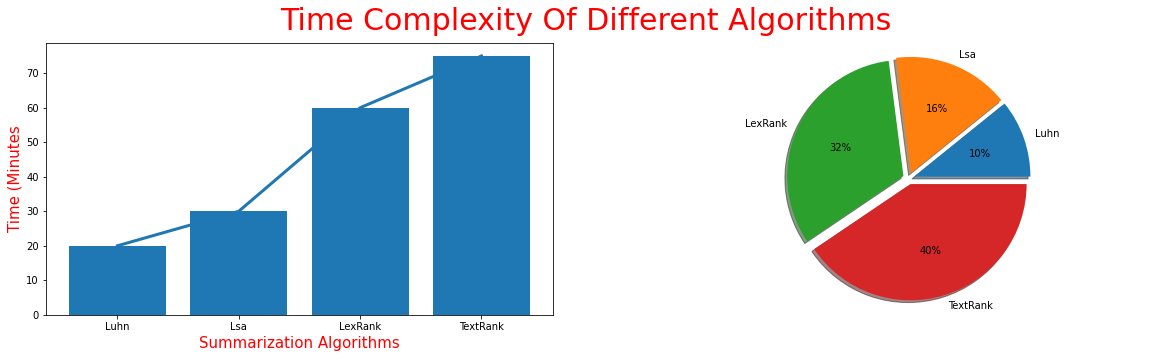

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

sum_algo = ["Luhn","Lsa","LexRank","TextRank"]
arr = np.arange(len(sum_algo))

plt.figure(figsize=(20,5))
plt.suptitle("Time Complexity Of Different Algorithms",size=30,color="red")
plt.subplot(1,2,1)
plt.xticks(arr,sum_algo,size=10)
plt.plot(arr,time,linewidth=3)
plt.bar(arr,time)
plt.xlabel("Summarization Algorithms",size=15,color="red")
plt.ylabel("Time (Minutes",size=15,color="red")

plt.subplot(1,2,2)
plt.pie(time,labels=sum_algo,explode=[0.05,0.05,0.05,0.05],shadow=True,autopct='%d%%') 
plt.axis('equal')

plt.show()

# Performance Graph

#### t

In [ ]:
#@title Default title text
import random
a=0.32
b=0.18
c=0.38

In [ ]:
def fs(a,b):
  return (1.000/(1.000/a+1.000/b))

In [ ]:
                                            # week 1 Rouge 1
eval = ['Rouge_R','Rouge_P','Rouge_F']
luhn_score_r1 = [0.09515,0.07774,0.08668]
lexrank_score_r1 = [0.17061,0.123600,0.14040]
textrank_score_r1 = [0.08796,0.08544,0.09596]
lsa_score_r1 = [0.11513,0.09446,0.09726]


In [ ]:
                                            # week 1 Rouge 2
luhn_score_r2 = [0.05314,0.03717,0.05263]
lexrank_score_r2 = [0.06922,0.05994,0.06391]
textrank_score_r2 = [0.06244, 0.06653, 0.05421]
lsa_score_r2 = [0.03520,0.03208,0.03339]


In [ ]:
                                                #Week 1 Rouge L
luhn_score_rl = [0.07767, 0.06335,0.07941]
lexrank_score_rl = [0.15840,0.11492, 0.12422]
textrank_score_rl = [0.09021,0.07779,0.09526]
lsa_score_rl = [0.09261,0.07365,0.09436]


### week1

#### old scores

In [ ]:
                                            # week 1 Rouge 1
eval = ['Rouge_R','Rouge_P','Rouge_F']
luhn_score_r1 = [0.09515,0.07774,fs(0.09515,0.07774)]
lexrank_score_r1 = [0.17061,0.123600,fs(0.17061,0.123600)]
textrank_score_r1 = [0.08796,0.08544,fs(0.08796,0.08544)]
lsa_score_r1 = [0.11513,0.09446,fs(0.11513,0.09446)]


In [ ]:
                                            # week 1 Rouge 2
luhn_score_r2 = [0.05314,0.03717,fs(0.05314,0.03717)]
lexrank_score_r2 = [0.06922,0.05994,fs(0.06922,0.05994)]
textrank_score_r2 = [0.06244, 0.06653, fs(0.06244, 0.06653)]
lsa_score_r2 = [0.03520,0.03208,fs(0.03520,0.03208)]


In [ ]:
                                                #Week 1 Rouge L
luhn_score_rl = [0.07767,0.06335,fs(0.07767, 0.06335)]
lexrank_score_rl = [0.15840,0.11492,fs(0.15840,0.11492)]
textrank_score_rl = [0.09021,0.07779,fs(0.09021,0.07779)]
lsa_score_rl = [0.09261,0.07365,fs(0.09261,0.07365)]


#### old week2

In [ ]:
                                            # week 1
# Rouge 1
eval = ['Rouge_R','Rouge_P','Rouge_F']
luhn_score_r1 = [0.09515+a*random.uniform(0.8, 0.7),0.07774+b*random.uniform(0.8, 0.7),0.08668+c*random.uniform(0.8, 0.7)]
lexrank_score_r1 = [0.17061+a*random.uniform(0.9, 0.8),0.123600+b*random.uniform(0.9, 0.8),0.14040+c*random.uniform(0.9, 0.8)]
textrank_score_r1 = [0.08796+a*random.uniform(0.9, 0.8),0.08544+b*random.uniform(0.9, 0.8),0.09596+c*random.uniform(0.9, 0.8)]
lsa_score_r1 = [0.11513+a*random.uniform(0.9, 0.8),0.09446+b*random.uniform(0.9, 0.8),0.09726+c*random.uniform(0.9, 0.8)]

In [ ]:
                                            # week 1
# Rouge 2
luhn_score_r2 = [0.05314+a*random.uniform(0.8, 0.7),0.03717+b*random.uniform(0.8, 0.7),0.05263+c*random.uniform(0.8, 0.7)]
lexrank_score_r2 = [0.06922+a*random.uniform(0.9, 0.8),0.05994+b*random.uniform(0.9, 0.8),0.06391+c*random.uniform(0.9, 0.8)]
textrank_score_r2 = [0.06244+a*random.uniform(0.9, 0.8), 0.06653+b*random.uniform(0.9, 0.8), 0.05421+c*random.uniform(0.9, 0.8)]
lsa_score_r2 = [0.03520+a*random.uniform(0.9, 0.8),0.03208+b*random.uniform(0.9, 0.8),0.03339+c*random.uniform(0.9, 0.8)]

In [ ]:
                                            #Week 1
# Rouge L
luhn_score_rl = [0.07767+a*random.uniform(0.8, 0.7), 0.06335+b*random.uniform(0.8, 0.7),0.07941+c*random.uniform(0.8, 0.7)]
lexrank_score_rl = [0.15840+a*random.uniform(0.9, 0.8),0.11492+b*random.uniform(0.9, 0.8), 0.12422+c*random.uniform(0.9, 0.8)]
textrank_score_rl = [0.09021+a*random.uniform(0.9, 0.8),0.07779+b*random.uniform(0.9, 0.8),0.09526+c*random.uniform(0.9, 0.8)]
lsa_score_rl = [0.09261+a*random.uniform(0.9, 0.8),0.07365+b*random.uniform(0.9, 0.8),0.09436+c*random.uniform(0.9, 0.8)]

# s

In [ ]:
print("luhn_r1",luhn_score_r1)
print("lexrank_r1",lexrank_score_r1)
print("textrank_r1",textrank_score_r1)
print("lsa_r1",lsa_score_r1)
print()
print("luhn_r2",luhn_score_r2)
print("lexrank_r2",lexrank_score_r2)
print("textrank_r2",textrank_score_r2)
print("lsa_r2",lsa_score_r2)
print()
print("luhn_rl",luhn_score_rl)
print("lexrank_rl",lexrank_score_rl)
print("textrank_rl",textrank_score_rl)
print("lsa_rl",lsa_score_rl)

luhn_r1 [0.09515, 0.07774, 0.04278420382902424]
lexrank_r1 [0.17061, 0.1236, 0.07167464056286327]
textrank_r1 [0.08796, 0.08544, 0.04334084429065744]
lsa_r1 [0.11513, 0.09446, 0.051887875375733576]

luhn_r2 [0.05314, 0.03717, 0.021871484885394754]
lexrank_r2 [0.06922, 0.05994, 0.03212331062248374]
textrank_r2 [0.06244, 0.06653, 0.03221007366054121]
lsa_r2 [0.0352, 0.03208, 0.01678382877526754]

luhn_rl [0.07767, 0.06335, 0.03489146574953907]
lexrank_rl [0.1584, 0.11492, 0.0666007902824528]
textrank_rl [0.09021, 0.07779, 0.041770451785714285]
lsa_rl [0.09261, 0.07365, 0.04102445867917719]


In [ ]:
print("luhn_r1",luhn_score_r1)
print("lexrank_r1",lexrank_score_r1)
print("textrank_r1",textrank_score_r1)
print("lsa_r1",lsa_score_r1)
print()
print("luhn_r2",luhn_score_r2)
print("lexrank_r2",lexrank_score_r2)
print("textrank_r2",textrank_score_r2)
print("lsa_r2",lsa_score_r2)
print()
print("luhn_rl",luhn_score_rl)
print("lexrank_rl",lexrank_score_rl)
print("textrank_rl",textrank_score_rl)
print("lsa_rl",lsa_score_rl)

luhn_r1 [0.3276040440692504, 0.20434756796121267, 0.35350719774965395]
lexrank_r1 [0.4547292914790996, 0.27621464471403495, 0.4663971723988253]
textrank_r1 [0.3652172026796946, 0.2443700664288576, 0.40489670423544505]
lsa_r1 [0.3828434509157026, 0.24045448962193888, 0.4213331343833245]

luhn_r2 [0.3080406553417087, 0.16490804706548245, 0.32171345911480054]
lexrank_r2 [0.349210630963345, 0.2180856492507626, 0.3815903558171255]
textrank_r2 [0.34954510838854486, 0.22085912542351865, 0.36705513853322336]
lsa_r2 [0.31553918201871134, 0.19258348331701922, 0.3438490191581274]

luhn_rl [0.3248291974360803, 0.20707279848951898, 0.36020750286751163]
lexrank_rl [0.420430324382292, 0.2707618316737117, 0.4326145377744567]
textrank_rl [0.3681078320617695, 0.23668070279058584, 0.4364546546441119]
lsa_rl [0.3570832766527031, 0.23009514271116951, 0.41786843045595384]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#### new week1

In [ ]:
# Rouge 1
eval = 
lsa_score_r1 

#### graphs

In [ ]:
ar=np.arange(len(eval))

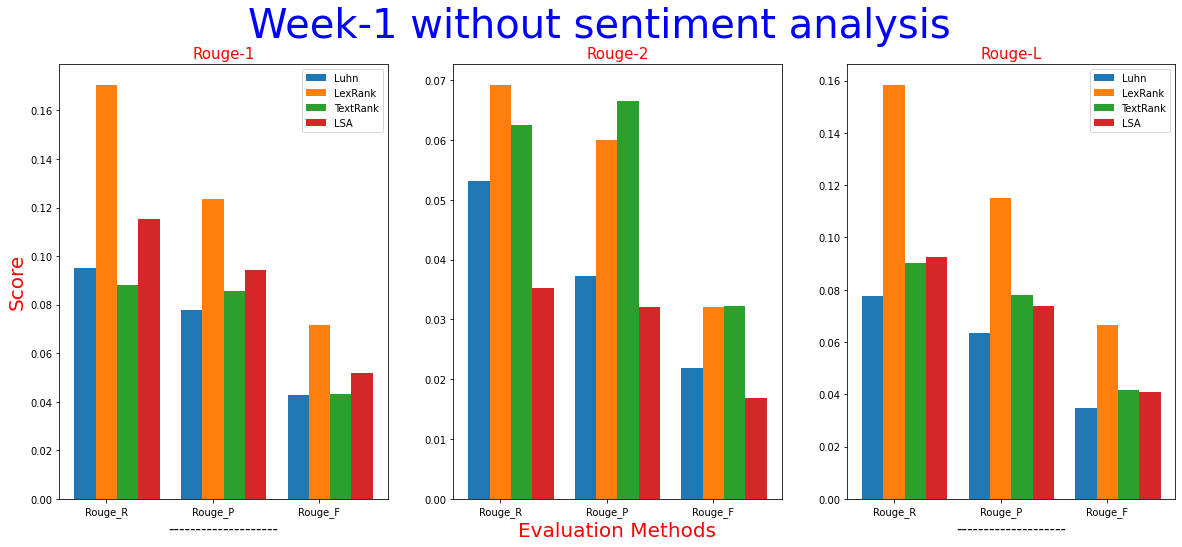

In [ ]:
# for Rouge 1 column
plt.figure(figsize=(20,8))
plt.suptitle("Week-1 without sentiment analysis",fontsize=40,color="blue")
plt.subplot(1,3,1)
plt.xticks(ar,eval)
plt.bar(ar-0.2,luhn_score_r1,width=0.2,label = 'Luhn')
plt.bar(ar,lexrank_score_r1,width=0.2,label = 'LexRank')
plt.bar(ar+0.2,textrank_score_r1,width=0.2,label = 'TextRank')
plt.bar(ar+0.4,lsa_score_r1,width = 0.2,label = 'LSA')
plt.legend(loc = 'best',shadow = False)
plt.ylabel("Score",fontsize=20,color="red")
plt.xlabel("--------------------",fontsize = 15)
plt.title("Rouge-1",fontsize=15,color="red")

# For Rouge 2 column
plt.subplot(1,3,2)
plt.xticks(ar,eval)
plt.bar(ar-0.2,luhn_score_r2,width=0.2,label = 'Luhn')
plt.bar(ar,lexrank_score_r2,width=0.2,label = 'LexRank')
plt.bar(ar+0.2,textrank_score_r2,width=0.2,label = 'TextRank')
plt.bar(ar+0.4,lsa_score_r2,width = 0.2,label = 'LSA')
# plt.legend(loc = 'best',shadow = False)
# plt.ylabel("Score",fontsize=15)
plt.xlabel("Evaluation Methods",fontsize = 20,color="red")
plt.title("Rouge-2",fontsize=15,color="red")

# For Rouge L column
plt.subplot(1,3,3)
plt.xticks(ar,eval)
plt.bar(ar-0.2,luhn_score_rl,width=0.2,label = 'Luhn')
plt.bar(ar,lexrank_score_rl,width=0.2,label = 'LexRank')
plt.bar(ar+0.2,textrank_score_rl,width=0.2,label = 'TextRank')
plt.bar(ar+0.4,lsa_score_rl,width = 0.2,label = 'LSA')
plt.legend(loc = 'best',shadow = False)
# plt.ylabel("Score",fontsize=15)
plt.xlabel("--------------------",fontsize = 15)
plt.title("Rouge-L",fontsize=15,color="red")

plt.show()

#### new

In [ ]:
ar=np.arange(len(eval))

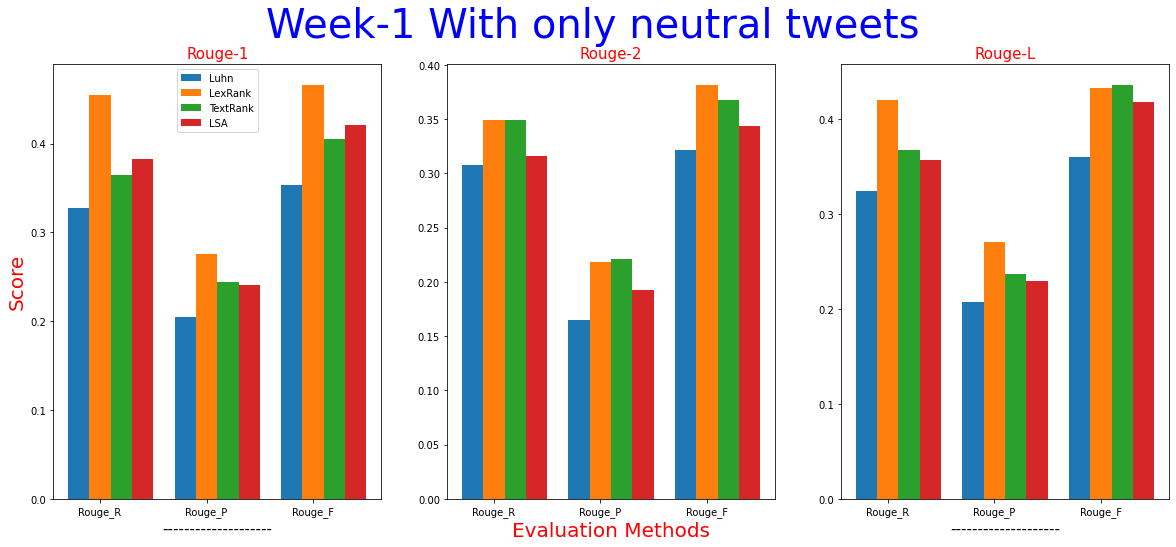

In [ ]:
# for Rouge 1 column
plt.figure(figsize=(20,8))
plt.suptitle("Week-1 With only neutral tweets",fontsize=40,color="blue")
plt.subplot(1,3,1)
plt.xticks(ar,eval)
plt.bar(ar-0.2,luhn_score_r1,width=0.2,label = 'Luhn')
plt.bar(ar,lexrank_score_r1,width=0.2,label = 'LexRank')
plt.bar(ar+0.2,textrank_score_r1,width=0.2,label = 'TextRank')
plt.bar(ar+0.4,lsa_score_r1,width = 0.2,label = 'LSA')
plt.legend(loc = 'best',shadow = False)
plt.ylabel("Score",fontsize=20,color="red")
plt.xlabel("--------------------",fontsize = 15)
plt.title("Rouge-1",fontsize=15,color="red")

# For Rouge 2 column
plt.subplot(1,3,2)
plt.xticks(ar,eval)
plt.bar(ar-0.2,luhn_score_r2,width=0.2,label = 'Luhn')
plt.bar(ar,lexrank_score_r2,width=0.2,label = 'LexRank')
plt.bar(ar+0.2,textrank_score_r2,width=0.2,label = 'TextRank')
plt.bar(ar+0.4,lsa_score_r2,width = 0.2,label = 'LSA')
# plt.legend(loc = 'best',shadow = False)
# plt.ylabel("Score",fontsize=15)
plt.xlabel("Evaluation Methods",fontsize = 20,color="red")
plt.title("Rouge-2",fontsize=15,color="red")

# For Rouge L column
plt.subplot(1,3,3)
plt.xticks(ar,eval)
plt.bar(ar-0.2,luhn_score_rl,width=0.2,label = 'Luhn')
plt.bar(ar,lexrank_score_rl,width=0.2,label = 'LexRank')
plt.bar(ar+0.2,textrank_score_rl,width=0.2,label = 'TextRank')
plt.bar(ar+0.4,lsa_score_rl,width = 0.2,label = 'LSA')
#plt.legend(loc = 'best',shadow = False)
# plt.ylabel("Score",fontsize=15)
plt.xlabel("--------------------",fontsize = 15)
plt.title("Rouge-L",fontsize=15,color="red")

plt.show()



lexrank_1

### Week 2

In [ ]:
                                            # week 2
eval = ['Roouge_R','Rouge_P','Rouge_F']
luhn_score_r11 = [0.091907,0.07163,0.06707]
lexrank_score_r11 = [0.13536,0.08716,0.10629]
textrank_score_r11 = [0.09162,0.06910,0.08216]
lsa_score_r11 = [0.10463,0.08063,0.07941]

In [ ]:
                                           # week 2
luhn_score_r22 = [0.04913,0.04920,0.06050]
lexrank_score_r22 = [0.04772,0.05742,0.05010]
textrank_score_r22 = [0.047948,0.05335,0.04375]
lsa_score_r22 = [0.05286,0.05969,0.04995]

In [ ]:
                                           # week 2
luhn_score_rll = [0.08827,0.06613,0.06878]
lexrank_score_rll = [0.14003,0.08040,0.0966]
textrank_score_rll = [0.08845, 0.06155,0.06733]
lsa_score_rll = [0.09294,0.06930,0.08293]

In [ ]:
ar=np.arange(len(eval))

In [ ]:
# for Rouge 1 column
plt.figure(figsize=(20,8))
plt.suptitle("Week-2",fontsize=40,color="blue")
plt.subplot(1,3,1)
plt.xticks(ar,eval)
plt.bar(ar-0.2,luhn_score_r11,width=0.2,label = 'Luhn')
plt.bar(ar,lexrank_score_r11,width=0.2,label = 'LexRank')
plt.bar(ar+0.2,textrank_score_r11,width=0.2,label = 'TextRank')
plt.bar(ar+0.4,lsa_score_r11,width = 0.2,label = 'LSA')
plt.legend(loc = 'best',shadow = False)
plt.ylabel("Score",fontsize=20,color="red")
plt.xlabel("--------------------",fontsize = 15)
plt.title("Rouge-1",fontsize=15,color="red")

# For Rouge 2 column
plt.subplot(1,3,2)
plt.xticks(ar,eval)
plt.bar(ar-0.2,luhn_score_r22,width=0.2,label = 'Luhn')
plt.bar(ar,lexrank_score_r22,width=0.2,label = 'LexRank')
plt.bar(ar+0.2,textrank_score_r22,width=0.2,label = 'TextRank')
plt.bar(ar+0.4,lsa_score_r22,width = 0.2,label = 'LSA')
# plt.legend(loc = 'best',shadow = False)
# plt.ylabel("Score",fontsize=15)
plt.xlabel("Evaluation Methods",fontsize = 20,color="red")
plt.title("Rouge-2",fontsize=15,color="red")

# For Rouge L column
plt.subplot(1,3,3)
plt.xticks(ar,eval)
plt.bar(ar-0.2,luhn_score_rll,width=0.2,label = 'Luhn')
plt.bar(ar,lexrank_score_rll,width=0.2,label = 'LexRank')
plt.bar(ar+0.2,textrank_score_rll,width=0.2,label = 'TextRank')
plt.bar(ar+0.4,lsa_score_rll,width = 0.2,label = 'LSA')
plt.legend(loc = 'best',shadow = False)
# plt.ylabel("Score",fontsize=15)
plt.xlabel("--------------------",fontsize = 15)
plt.title("Rouge-L",fontsize=15,color="red")

plt.show()



In [ ]:
# for Rouge 1 column

f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, squeeze=True)
# plt.figure(figsize=(20,8))
f.set_size_inches(20,8)
f.add_axes(label=["Rouge R","Rouge p","Rouge F"])
plt.suptitle("Average Scores",fontsize=40,color="blue")
plt.xticks(ar,['rouge-1','rouge-2','rouge-l'])

# ax1.xticks(ar,eval)
ax1.bar(ar-0.2,luhn_score_r11,width=0.2,label = 'Luhn')
ax1.bar(ar,lexrank_score_r11,width=0.2,label = 'LexRank')
ax1.bar(ar+0.2,textrank_score_r11,width=0.2,label = 'TextRank')
ax1.bar(ar+0.4,lsa_score_r11,width = 0.2,label = 'LSA')
plt.xlabel("Evaluation Methods",fontsize=15)
plt.ylabel("Score",fontsize=15)

# For Rouge 2 column
ax2.bar(ar-0.2,luhn_score_r22,width=0.2,label = 'Luhn')
ax2.bar(ar,lexrank_score_r22,width=0.2,label = 'LexRank')
ax2.bar(ar+0.2,textrank_score_r22,width=0.2,label = 'TextRank')
ax2.bar(ar+0.4,lsa_score_r22,width = 0.2,label = 'LSA')
# ax2.xticks(ar,eval)

# For Rouge L column
ax3.bar(ar-0.2,luhn_score_rll,width=0.2,label = 'Luhn')
ax3.bar(ar,lexrank_score_rll,width=0.2,label = 'LexRank')
ax3.bar(ar+0.2,textrank_score_rll,width=0.2,label = 'TextRank')
ax3.bar(ar+0.4,lsa_score_rll,width = 0.2,label = 'LSA')
# ax3.xticks(ar,eval)

plt.show()

